# Amortized posterior inference on Gaussian example

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/01_gaussian_amortized.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/01_gaussian_amortized.ipynb) in the `sbi` repository.

In this tutorial, we introduce **amortization** that is the capability to evaluate the posterior for different observations without having to re-run inference.

We will demonstrate how `sbi` can infer an amortized posterior for the illustrative linear Gaussian example introduced in [Getting Started](00_getting_started_flexible.ipynb), that takes in 3 parameters ($\theta$). 

In [3]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

## Defining simulator, prior, and running inference

Our  _simulator_ (model) takes in 3 parameters ($\theta$) and outputs simulations of the same dimensionality. It adds 1.0 and some Gaussian noise to the parameter set. For each dimension of $\theta$, we consider a uniform _prior_ between [-2,2].

In [2]:
num_dim = 3


In [32]:
import sys
sys.path.append('../Matlab2Py/')

from offline_matlab import OfflineEngine

import numpy as np
import random


def init_simulator(SIMULATION_PATH, model_name,):
    #Here you setup your simulation configuration & initalzie necessary variables 


    MODEL_PATH = f"{SIMULATION_PATH}{model_name}.slx"
    
    eng = OfflineEngine(model_path = MODEL_PATH, sim_path = SIMULATION_PATH, model_name = model_name)
    eng.load_engine()
    #Run the simple_sim/init.m to initalize theta
    eng.run_engine_script('init')
    eng.set_simulation_mode(s_mode='normal')

    return eng

SIMULATION_PATH = 'simple_sim/'
model_name = 'test'
eng = init_simulator(SIMULATION_PATH=SIMULATION_PATH, model_name=model_name)



In [34]:

def run_simulation(eng, theta : list[3]):
    if type(theta) == torch.Tensor:
        theta = theta.tolist()
       
    seeds = np.random.randint(0, np.iinfo(np.int32).max, size = num_dim)

    o = eng.run_full_sim(blocks_inputs={'gau' : (seeds, 'seed'), 'theta' : (theta, 'Value')})
    return eng.get_simoutput(o, 'simout')


def simulator(eng):
    def _simulator(inputs):
        output = (torch.Tensor(run_simulation(eng, theta)).squeeze() for theta in inputs)
        return torch.stack((*output,) )
    return _simulator


simul = simulator(eng)

In [35]:
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))


# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simul = process_simulator(simul, prior, prior_returns_numpy)
check_sbi_inputs(simul, prior)

[-1.0495095252990723, -0.8858451843261719, 0.9059114456176758] [[-0.02867730777124109,0.03817468086210174,1.9783324901194326]]
[-0.534801721572876, -0.04720473289489746, 0.1421070098876953] [[0.365006751197294,1.0692902013048484,1.060945220194392]]
[-1.7357046604156494, 0.9401614665985107, 1.0035202503204346] [[-0.7061409324441082,1.9389325110306619,1.8468089483527277]]


In [23]:
# Create inference object. Here, NPE is used.
inference = SNPE(prior=prior)

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simul, proposal=prior, num_simulations=2000)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.: 100%|██████████| 2000/2000 [07:01<00:00,  4.74it/s]


 Neural network successfully converged after 57 epochs.

## Amortized inference
Note that we have not yet provided an observation to the inference procedure. In fact, we can evaluate the posterior for different observations without having to re-run inference. This is called **amortization**. An amortized posterior is one that is not focused on any particular observation. Naturally, if the diversity of observations is large, any of the inference methods will need to run a sufficient number of simulations for the resulting posterior to perform well across these diverse observations.

Let's say we have not just one but two observations $x_{obs~1}$ and $x_{obs~2}$ for which we aim to do parameter inference. 

> Note: For real observations, of course, you would not have access to the ground truth $\theta$.

In [24]:
# generate the first observation
theta_1 = prior.sample((1,))
x_obs_1 = simul(theta_1)
# now generate a second observation
theta_2 = prior.sample((1,))
x_obs_2 = simul(theta_2)

We can draw samples from the posterior given $x_{obs~1}$ and then plot them:

Drawing 10000 posterior samples: 10060it [00:00, 71260.86it/s]                          


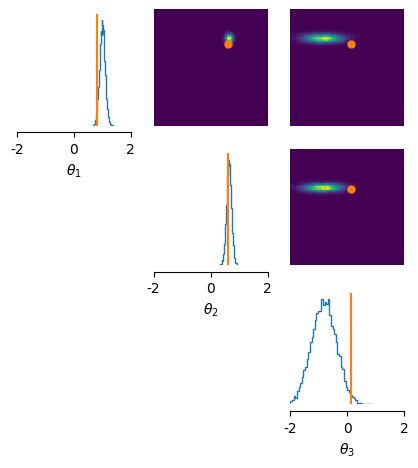

In [25]:
posterior_samples_1 = posterior.sample((10000,), x=x_obs_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_1 # add ground truth thetas
)

The inferred distirbutions over the parameters given the **first** observation $x_{obs~1}$ match the parameters $\theta_{1}$ (shown in orange), we used to generate our first observation $x_{obs~1}$.

Since the learned posterior is **amortized**, we can also draw samples from the posterior given the second observation $x_{obs~2}$ without having to re-run inference:

Drawing 10000 posterior samples: 10096it [00:00, 85783.41it/s]                          


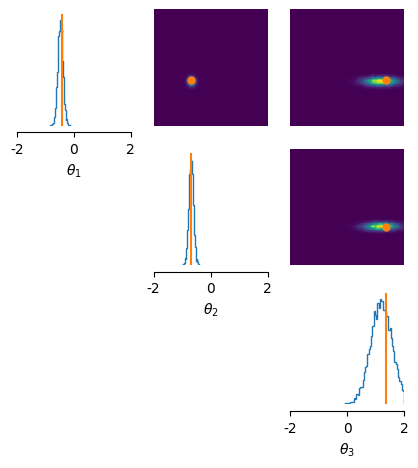

In [26]:
posterior_samples_2 = posterior.sample((10000,), x=x_obs_2)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_2, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_2 # add ground truth thetas
)

The inferred distirbutions over the parameters given the **second** observation  $x_{obs~2}$ also match the ground truth parameters $\theta_{2}$ we used to generate our second test observation  $x_{obs~2}$.

This in a nutshell demonstrates the benefit of amortized methods. 

# Next steps

Now that you got familiar with amortization and are probably good to go and have a first shot at applying `sbi` to your own inference problem. If you want to learn more, we recommend checking out our tutorial on
[multiround inference ](03_multiround_inference.ipynb) which aims to make inference for a single observation more sampling efficient.